# Adaptive Stepsize for solving ODEs

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Adaptive Step Size Runge-Kutta Integrators

We have now explored several methods for integrating ODEs in this class, and in each case we have taken a fixed step size. There is an obvious way to do better than this: we can vary our step size so that when our function is changing rapidly, we take very small steps, and when our function is varying slowly and smoothly, we lengthen our stride. In the words of the great textbook Numerical Recipes, "many small steps should tiptoe through treacherous terrain, while a few great strides should speed through smooth uninteresting countryside." Let's look at this idea in more detail.

### Step Doubling
If we want to judiciously choose our adaptive stepsizes, we will need to estimate how big a step to take at any given moment. The simplest way to achieve this is called *step doubling*. We will compare what we get by taking two normal steps with what we get taking one step of twice the size. By comparing these two estimates we can determine the accuracy of our calculation. 

Let's let $x(t + 2h)$ denote the exact solution for a step from $t$ to $t+2h$. Let's compare the two approximate solutions $x_1$ (one step of size $2h$) and $x_2$ (two steps each of size $h$). We recall that the RK4 integrator is fourth-order accurate, and thus accumulates errors as $h^5$, where $h$ is our stepsize. (In many physics applications this $h$ is our timestep, and we have been sometimes been calling it $\Delta t$. Here I'm using $h$ to avoid the notational annoyance of writing powers of $\Delta t$.)

$$x(t + 2h) = x_1 + (2h)^5 c$$
$$x(t + 2h) = x_2 + 2(h^5) c$$

The first expression has $(2h)^5$ because the stepsize is $2h$, and the second expression takes two steps of size $h$, so we have a term $2h^5$. The $c$ in these expressions is a constant (which we know from the Taylor series is of order $\frac{d^5x}{dt^5}/5!$).

Equating these expressions gives us a handy way to measure the per-step truncation error $\epsilon = ch^5$:

$$\epsilon = ch^5 = \frac{1}{30}\left|x_2 - x_1\right|$$

where we are taking the absolute value because we care about the absolute magnitude of the error, and not its sign. The goal is to make this error equal to some target accuracy. 

&#128310; In your own words, if $\epsilon$ is smaller than our target accuracy, what does that mean, and what should happen? If $\epsilon$ is larger than our target accuracy, what should happen? 

If $\epsilon$ is smaller than our target accuracy, then our answer will be satisfyingly accurate. This means that the we are okay with the error $\epsilon$ that is within our calulation of each step. If $\epsilon$ is larger than our target accuracy, then we will see quickly that our estimate is far off what we expected the answer to be.

Let's imagine the perfect stepsize $h_{ideal}$ such that our error is exactly equal to the target error. If we take steps of size $h_{ideal}$, the error on a single step is

$$ch_{ideal}^5 = ch^5 \left(\frac{h_{ideal}}{h}\right)^5 = \frac{1}{30}(x_1 - x_2)\left(\frac{h_{ideal}}{h}\right)^5$$

where we have subbed in the equation above. Let's say we want a solution with a target accuracy of $\delta h_{ideal}$. We thus find

$$h_{ideal} = h \rho^{1/4}$$

where

$$\rho = \frac{30 h \delta}{\left|x_1 - x_2\right|}$$

is the ratio of the target accuracy and the actual accuracy for steps of size $h$. The idea is to timestep our system forward, and evaluate whether $\rho$ is greater than or equal to 1 at each step, adjusting our step size accordingly. Note that we typically want to set a maximum possible timestep adjustment, typically $2h$. When we adjust our timestep we will thus set it to the minimum of $2h$ and $h \rho^{1/4}$.

### Implementing Step Doubling with RK4

Let's try our own implementation of step doubling. First we'll need an RK4 stepper.

Recall that an RK4 step is calculated as follows:

$$x_{k+1} = x_k + \frac{h}{6}\left(f_1 + 2f_2 + 2f_3 + f_4\right)$$

where

$$f_1 = f(x_k, t_k)$$
$$f_2 = f(x_k + \frac{h}{2}f_1, t_k + \frac{h}{2} )$$
$$f_3 = f(x_k + \frac{h}{2}f_2, t_k + \frac{h}{2} )$$
$$f_4 = f(x_k + h f_3, t_k + h)$$

&#128309; Write a function `rk4step` that takes a function `func`, current state of the system `xk`, and stepsize `h`, and returns the next state of the system according to the RK4 algorithm. Note that this version of an RK4 step will not depend explicitly on time. Can you write your `rk4step` function in 6 lines? 

In [2]:
def rk4step(func, xk, h):
    f1 = func(xk)
    f2 = func(xk + (h/2)*f1)
    f3 = func(xk + (h/2)*f2)
    f4 = func(xk + h*f3)
    return xk + (h/6)*(f1 + 2*f2 + 2*f3 + f4) # written in 6 lines ✅

&#128309; Write a function `rk4adaptivestep` that takes a function `func`, current state of the system `xk`, and stepsize `h`, following the comments below.

In [3]:
def rk4adaptivestep(func, xk, h):
    # Perform one step of size 2h and store the output as x1
    x1 = rk4step(func, xk, 2*h)

    # Perform two steps of size h and store the output as x2
    x_middle = rk4step(func, xk, h)
    x2 = rk4step(func, x_middle, h)
    
    # Return the difference between the two results and the result with stepsize h
    return abs(x1 - x2), x2

## A comet approaches the Sun

Consider a comet in orbit around the Sun. In the plane of its orbit, its position is governed by two second-order differential equations:

$$\frac{d^2x}{dt^2} = -GM\frac{x}{r^3}$$
$$\frac{d^2y}{dt^2} = -GM\frac{y}{r^3}$$

where $r = \sqrt{x^2 + y^2}$.

&#128310; Write this system as four first-order differential equations. *Hint:* your equations will govern $x, y, v_x, v_y$. 

$$ v_x = \frac{dx}{dt} $$
$$ v_y = \frac{dy}{dt} $$
$$ x = - GM \frac{x^3}{6r^3} $$
$$ y = - GM \frac{x^3}{6r^3} $$

&#128309; Write a function `comet` that takes a length-4 array `vec` containing $[x, y, v_x, v_y]$, and returns a length-4 array with $\frac{d \mathrm{vec}}{dt}$, i.e., a function that computes your four ODEs above. Look up the mass of the Sun and the Gravitational constant. You may choose to work in SI units (but it is up to you as long as you are consistent). 

In [19]:
def comet(vec):
    # define constants
    G = 6.67430 * 10**(-11) # Nm^2/kg^2 
    M = 1.9891 * 10**(30) # kg
    r = np.sqrt(abs(vec[0]**2 + vec[1]**2)) # m

    dvec_dt = np.zeros(4)
    dvec_dt[0] = vec[2] # calculate x update
    dvec_dt[1] = vec[3] # calculate y update
    dvec_dt[2] = - G*M*vec[0]/(r**3) # calculate v_x update
    dvec_dt[3] = - G*M*vec[1]/(r**3) # calculate v_y update
    return dvec_dt

&#128310; Note that if we are writing an adaptive method for a system of equations, we will end up computing $\rho$ for each variable. A reasonable choice here is to compute the error on the distance from the Sun, i.e. $\sqrt{x^2 + y^2}$. Write down what your $\rho$ will be in this case.

$$\rho = \frac{30 h \delta}{\left|r_1 - r_2  \right|} =  \frac{30 h \delta}{\left| \sqrt{x_1^2 + y_1^2} - \sqrt{x_2^2 + y_2^2}  \right|}$$

&#128309; Let's say your comet begins 4 billion km from the Sun, around the orbit of Neptune, with initial velocity $v_x = 0$ and $v_y = 500~\mathrm{m/s}$ at time=0. Implement an adaptive RK4 scheme to follow the path of your comet for 40 years, following the comments below. Set a target accuracy for the comet's position of $\delta = 1$ km/year. Think carefully about each step, and be careful with units!

In [20]:
# Initialize empty lists xpoints and ypoints to store the output
xpoints, ypoints = [], []

# Initialize a variable t to store the current time. Also initialize delta and any other constants you need
t = 0 # sec
x = 4e12 # m
y = 0 # m
v_x = 0 # m/s
v_y = 500 # m/s
t_max = 40*365*24*3600 # years * (days/year) * (hours/day) * (sec/hour) = sec
delta = 1000 * 3.17098*10**(-8) # m/year * (year / sec) = m/sec

# Initialize your timestep h. Start with something relatively small! Denote the units of your choice. 
h = 1 # sec

# Initialize your state vector x. This should be a length-4 numpy array.
x_vec = np.array([x, y, v_x, v_y])

# Start a while loop that will run until you achieve the final time
while t < t_max:

    # Perform an adaptive step with the current value of your stepsize h. Store the difference and the new state vector as vecdiff and xnew. 
    vecdiff, xnew = rk4adaptivestep(comet, x_vec, h)
    
    # Calculate rho
    r_error = np.sqrt(vecdiff[0]**2 + vecdiff[1]**2)
    rho = (30*h*delta)/r_error

    # If rho is greater than or equal to 1, increase your stepsize and append your results to xpoints and ypoints
    if rho >= 1:
        # Update t, keeping in mind that we just stepped forward 2h
        t += 2*h

        # Update h, setting it to the smaller of 2h and h*rho^(1/4)
        h = min(2*h, h*rho**(1/4))

        # Update x and append the results to xpoints and ypoints
        x_vec = xnew
        xpoints.append(x_vec[0])
        ypoints.append(x_vec[1])

    # If rho is less than 1, decrease your stepsize and do not append your result to the output
    elif rho < 1:

        # Update h, setting it to h*rho^(1/4)
        h = h*rho**(1/4)

    else:
        print("something not working : ()")

/var/folders/9r/sw7rn4810sjddctl8q8nlcy80000gn/T/ipykernel_84296/2500953681.py:27: RuntimeWarning: divide by zero encountered in scalar divide
  rho = (30*h*delta)/r_error


&#128309; Plot the journey of your comet through space, i.e. its x-y coordinates as a function of time. Plot each timestep as a dot. You may want to play with the markersize.

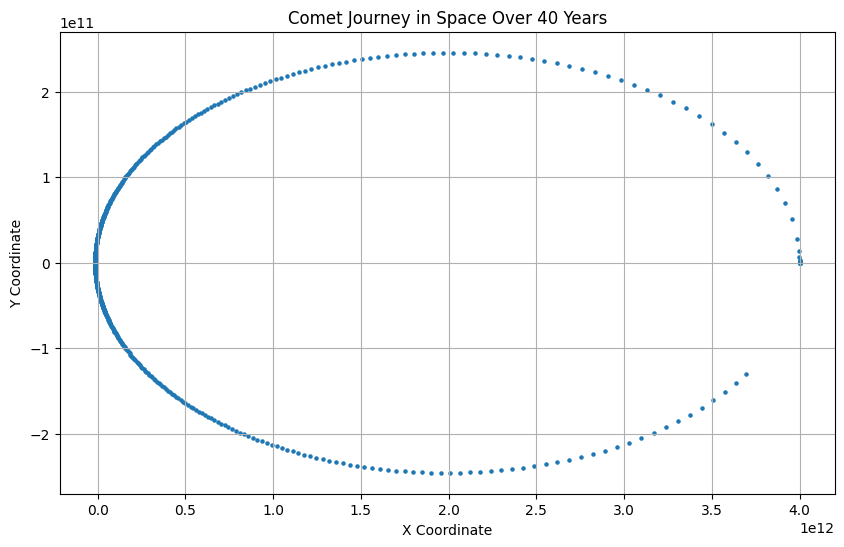

In [42]:
# plot comet's path
plt.figure(figsize=(10, 6))
plt.scatter(xpoints, ypoints, s=5)

# plot labels
plt.title('Comet Journey in Space Over 40 Years')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.grid(True)
plt.show()

&#128309; Plot the journey of your comet through space a second time. This time also plot the position of the Sun at $(x, y) = (0, 0)$. Adjust the axis limits of your plot until you have a good view of the time that the comet spends near the Sun. Label everything nicely. 

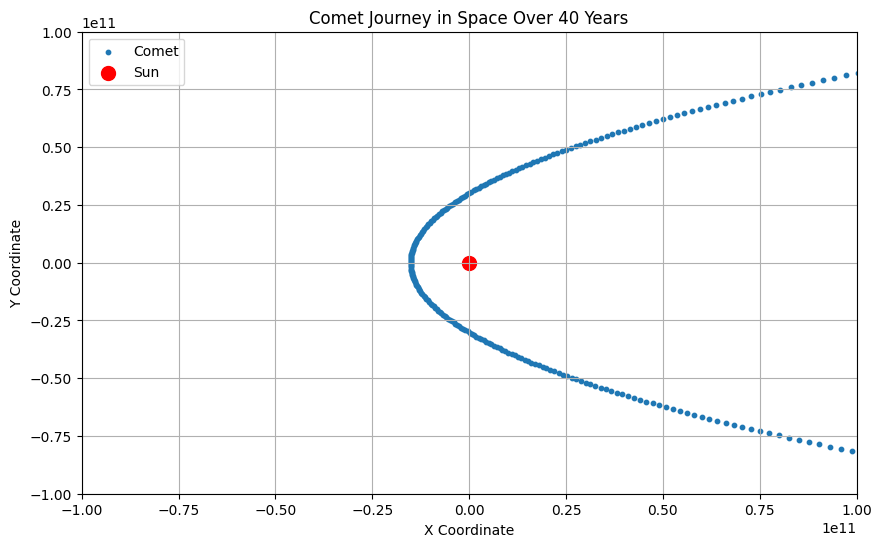

In [41]:
# plot comet's path
plt.figure(figsize=(10, 6))
plt.scatter(xpoints, ypoints, s=10, label="Comet")

# plot sun
plt.scatter(0, 0, color="red", marker="o", s=100, label="Sun")

# plot labels
plt.title('Comet Journey in Space Over 40 Years')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.grid(True)

# readjust axis
plt.xlim(-1e11, 1e11)
plt.ylim(-1e11, 1e11)

# plot
plt.legend()
plt.show()

&#128310; Describe in words what is happening in your plot, in terms of both the stepsize your integrator used, and the physics of the comet's journey.

In my plot, we recognize that the comet is "slinging" around the sun, or is it an ecliptical orbit around the Sun. We can tell that the comet gets extraordinarily close to the sun in the closest part of its orbit. Now as we consider the stepsize the integrator used, we recognize that in the highest force environments, namely the closest parts to the sun, we use much smaller step sizes. This allows us to consider more exactly what the effect of the high forces are we making the step size much smaller. 

Now that you have tackled this, you are ready to take on the three-body problem! That is a fascinating system that you may wish to explore. 

## The Lotka-Volterra equations

We can write down a system of equations that models predator-prey interactions, e.g. between rabbits (`x`) and wolves (`y`). These are as follows:

$$\frac{dx}{dt} = ax - bxy$$
$$\frac{dy}{dt} = cxy - dy$$

&#128310; Describe these equations in your own words. Why do they have this form?

For the population of rabbits and wolves, it depends on the existing population of rabbits and wolves (each rabbit has some probability of repopulating) and then some competition factor between rabbits and wolves, hence the negative cross term. 

&#128309; Implement an adaptive RK scheme to solve these equations. Assume $a = 1, b = c = 0.5, d = 2$, and assume that $x$ and $y$ represent the number of rabbits and wolves in units of thousands of animals. Evolve these equations forward from $t = 0$ to $t = 30$ years, storing both the rabbit and wolf population numbers and the time. 

In [90]:
a, b, c, d = 1, 0.5, 0.5, 2

def lotka_volterra(state):
    x, y = state[0], state[1]

    dx_dt = a*x - b*x*y
    dy_dt = c*x*y - d*y
    return np.array([dx_dt, dy_dt])

# Initialize empty lists xpoints and ypoints to store the output
xpoints, ypoints, time = [], [], []

# Initialize a variable t to store the current time. Also initialize delta and any other constants you need
t = 0 # years
t_max = 30 # years
delta = 1000 * 3.17098*10**(-8) # rabbits (in thousands) / year

# Initialize your timestep h. Start with something relatively small! Denote the units of your choice. 
h = 1 # years

# Initialize your state vector x. length 2 array
state = np.array([5, 5])

# Start a while loop that will run until you achieve the final time
while t < t_max:

    # Perform an adaptive step with the current value of your stepsize h. Store the difference and the new state vector as vecdiff and xnew. 
    vecdiff, state_new = rk4adaptivestep(lotka_volterra, state, h)
    
    # Calculate rho
    r_error = np.sqrt(vecdiff[0]**2 + vecdiff[1]**2)
    rho = (30*h*delta)/r_error

    # If rho is greater than or equal to 1, increase your stepsize and append your results to xpoints and ypoints
    if rho >= 1:
        # Update t, keeping in mind that we just stepped forward 2h
        t += 2*h

        # Update h, setting it to the smaller of 2h and h*rho^(1/4)
        h = min(2*h, h*rho**(1/4))

        # Update x and append the results to xpoints and ypoints
        state = state_new
        xpoints.append(state[0])
        ypoints.append(state[1])
        time.append(t)

    # If rho is less than 1, decrease your stepsize and do not append your result to the output
    elif rho < 1:

        # Update h, setting it to h*rho^(1/4)
        h = h*rho**(1/4)

    else:
        print("incorrect - rho: {:e}".format(rho))

&#128309; Plot the wolf and rabbit populations as a function of time. 

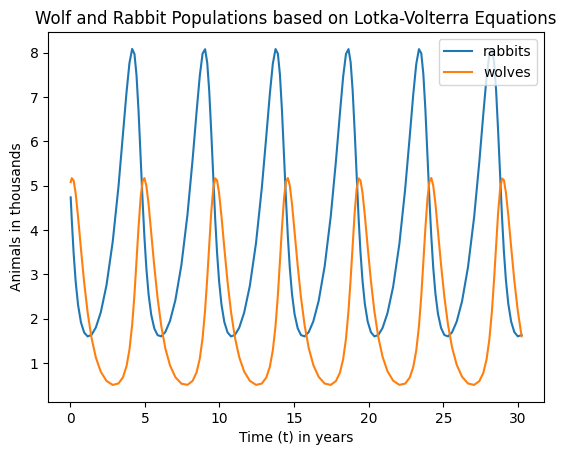

In [91]:
# plots of rabbits and wolves
plt.plot(time, xpoints, label="rabbits")
plt.plot(time, ypoints, label="wolves")

# labels
plt.xlabel("Time (t) in years")
plt.ylabel("Animals in thousands")
plt.title("Wolf and Rabbit Populations based on Lotka-Volterra Equations")

# plot
plt.legend()
plt.show()

&#128310; Explain your plot in your own words. 

As we analyze this plot, we recognize that over time, it seems there is some stability in the populations of rabbits and wolves. For one, the number of rabbits often surpasses the number of wolves. In fact, when this is not true, both the wolves and rabbit populations quickly die. Furthermore, it seems like the entire population has regular waves of growing and diminishing in response to the other population's behavior. We can also tell that the wolves population can get much lower than the minimum rabbit population. 

## Acknowledgments

S.E. Clark 2024, with inspiration from Numerical Recipes (3rd Edition) and problems adapted from Newman 2013.